In [1]:
# ЗАПУСТИТЬ этот код для корректного отображния кастомного колбэка вывода результатов обучения модели, если ноутбук открываете в Jypiter Notebook (в Colab запускать не обязательно) 
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # отображение всех ячеек ноутбука на всю ширину браузера
display(HTML("<style>pre { white-space: pre !important; }</style>")) # переключение на горизонтальную прокрутку в ячейке вывода для корректного отображения применяемого в обучении модели кастомного колбэка

In [7]:
!pip install openpyxl

     ---------------------------------------- 0.0/250.0 kB ? eta -:--:--
     ---- -------------------------------- 30.7/250.0 kB 660.6 kB/s eta 0:00:01
     --------- --------------------------- 61.4/250.0 kB 656.4 kB/s eta 0:00:01
     --------------------- ---------------- 143.4/250.0 kB 1.1 MB/s eta 0:00:01
     -------------------------------------  245.8/250.0 kB 1.4 MB/s eta 0:00:01
     -------------------------------------- 250.0/250.0 kB 1.2 MB/s eta 0:00:00


In [15]:
!pip install exif

     ---------------------------------------- 0.0/70.0 kB ? eta -:--:--
     ----- ---------------------------------- 10.2/70.0 kB ? eta -:--:--
     --------------------------------- ---- 61.4/70.0 kB 656.4 kB/s eta 0:00:01
     -------------------------------------- 70.0/70.0 kB 635.6 kB/s eta 0:00:00


In [2]:
import os
import uuid
from pathlib import Path, PureWindowsPath
import shutil
from shutil import ignore_patterns
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image, ImageOps
import PIL
import cv2
import random, math
import copy
import numpy as np
import pandas as pd
import sys
from tqdm import tqdm
from exif import Image as exifImage

# Функции и классы

In [3]:
def create_dataset_dirs_structure(root_dataset_dir, num_classes):
    root_dataset_path = os.path.join(os.getcwd(), root_dataset_dir)
    os.makedirs(root_dataset_path, exist_ok=True)
    for class_idx in range(num_classes):
        os.makedirs(os.path.join(root_dataset_path, str(class_idx)), exist_ok=True)

In [4]:
def remove_non_images(source_dataset_path, removed_non_images_dir, images_extensions, copy_only=True):
    classes_dirs = [class_dir for class_dir in os.listdir(source_dataset_path) if os.path.isdir(source_dataset_path+'/'+class_dir)]
    non_images_files_found = 0
    for class_dir in classes_dirs:
        class_non_images_files_paths = [file_path for file_path in Path(source_dataset_path+'/'+class_dir).iterdir() if file_path.suffix.lower() not in images_extensions]
        for file_path in class_non_images_files_paths:
            if copy_only:
                shutil.copy(file_path, removed_non_images_dir+'/'+class_dir)
            else:
                shutil.move(file_path, removed_non_images_dir+'/'+class_dir)
            non_images_files_found += 1
    copy_move = 'скопировано' if copy_only else 'перемещено'
    print(f'Найдено и {copy_move} {non_images_files_found} файлов не изображений')

In [5]:
def dataset_info(dataset_path, classes_names, classes_colors, header, classes_folders_names_type='class_name'):
    
    '''
    Функция подсчета и вывода статистик датасета
    '''

    def display_statistics_table_data():
        classes_info_display_list = []
        for class_idx in range(len(classes_names)):
            class_info_list = []
            class_info_list.append(class_idx)
            class_info_list.append(classes_names[class_idx])
            class_num_images = class_info_list.append(classes_images_num[class_idx])
            classes_info_display_list.append(class_info_list)        

        classes_display_headers = ['\nИндекс класса' ,'\nНазвание класса', 'Количество\nизображений по классам']
        print(tabulate(classes_info_display_list, headers=classes_display_headers, tablefmt='presto'))
        print()
        total_images_num = f'Общее количество изображений в датасете: {dataset_images_num}'
        selected_dataset_size = f'Размер датасета: {dataset_size:,.1f} Мб'
        dash_line = len(total_images_num)*'-'
        print(dash_line, total_images_num, selected_dataset_size, dash_line, sep='\n')        
        print()        

    def plot_diagram():
        plt.rcParams.update({'font.size': 8})      
        plt.figure(figsize=(round(len(classes_names))*0.75, 5), facecolor='deepskyblue')
        plt.subplot(fc='lightgoldenrodyellow')
        plt.title('Диаграмма количества изображений по классам', fontsize=8)
        plt.bar([f'class_{class_idx}' for class_idx in range(num_classes)], classes_images_num, width=0.7, color=classes_colors, edgecolor='black')
        plt.grid()
        plt.ylabel('Количество объектов в классе')

        handles = [plt.Rectangle((0,0),1,1, color=classes_colors[class_idx]) for class_idx in range(num_classes)]
        legend_classes_names = [f'class_{idx} '+class_name for idx, class_name in enumerate(classes_names)]
        legend = plt.legend(handles, legend_classes_names, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, framealpha=0)
        legend.set_title('Названия классов')
        plt.show()
        print()
  
    print()
    symbols_line = len(header)*'='
    print(symbols_line, header, symbols_line, sep='\n')
    print()

    if classes_folders_names_type == 'index':
        classes_folders_names = [str(class_index) for class_index in range(len(classes_names))]
        classes_images_num = [len(os.listdir(os.path.join(dataset_path, class_folder_name))) for class_folder_name in classes_folders_names] 
    elif classes_folders_names_type == 'class_name':
        classes_folders_names = [class_name for class_name in classes_names]
        classes_images_num = [len(os.listdir(os.path.join(dataset_path, class_folder_name))) for class_folder_name in classes_folders_names] 
    
    dataset_images_num = sum(classes_images_num)
    num_classes = len(classes_names)
    dataset_size = 0
    for class_folder_name in classes_folders_names:
        for file_name in os.listdir(os.path.join(dataset_path, class_folder_name)):
            dataset_size += os.path.getsize(os.path.join(dataset_path, class_folder_name, file_name))
    dataset_size = dataset_size / 1024 / 1024

    display_statistics_table_data()
    plot_diagram()

In [34]:
def dataset_images_size_info(dataset_path, classes_names, classes_colors, class_indexes_only, images_extensions):    
    
    '''
    Функция визуализации распределения размеров изображения и поиска максимальных и минимальных изображений в датасете
    '''
    
    all_classes_heights_list = []
    all_classes_widths_list = []
    all_classes_files_paths_list = []
    classes_heights_list_of_lists = []
    classes_widths_list_of_lists = []
    dataset_dirs = [str(i) for i in sorted([int(i) for i in os.listdir(dataset_path)])]
    if class_indexes_only is not None:
        dataset_dirs = [dataset_dirs[i] for i in class_indexes_only]
    for class_dir in dataset_dirs:
        class_heights_list = []
        class_widths_list = []
        class_files_paths = [file_path for file_path in Path(dataset_path+'/'+class_dir).iterdir() if file_path.suffix.lower() in images_extensions]
        for file_path in class_files_paths:            
            with Image.open(file_path) as im:
                width, height = im.size
            all_classes_files_paths_list.append(file_path)
            class_heights_list.append(height)
            class_widths_list.append(width)                                        
            all_classes_heights_list.append(height)
            all_classes_widths_list.append(width)
        classes_heights_list_of_lists.append(class_heights_list)
        classes_widths_list_of_lists.append(class_widths_list)
    max_heigth = max(all_classes_heights_list)
    min_heigth = min(all_classes_heights_list)
    max_heigth_index = all_classes_heights_list.index(max_heigth)
    min_heigth_index = all_classes_heights_list.index(min_heigth)
    max_width = max(all_classes_widths_list)
    min_width = min(all_classes_widths_list)
    max_width_index = all_classes_widths_list.index(max_width)
    min_width_index = all_classes_widths_list.index(min_width)
    
    header = 'Распределение высоты и ширины изображений в датасете'
    if class_indexes_only:
        header = f'Распределение высоты и ширины изображений в датасете по классу(ам) {", ".join(str(i) for i in class_indexes_only)}'
    
    print()
    symbols_line = len(header)*'='
    print(symbols_line, header, symbols_line, sep='\n')
    print()    
    
    title = 'Максимальная и минимальная высота изображений'
    dash_line = len(title)*'-'
    print(title, dash_line, sep='\n')
    print(f'максимальная: {max_heigth}')
    print(all_classes_files_paths_list[max_heigth_index])
    print(f'минимальная: {min_heigth}')
    print(all_classes_files_paths_list[min_heigth_index])
    print()
    title = 'Максимальная и минимальная ширина изображений'
    dash_line = len(title)*'-'
    print(title, dash_line, sep='\n')
    print(f'максимальная: {max_width}')
    print(all_classes_files_paths_list[max_width_index])
    print(f'минимальная: {min_width}')
    print(all_classes_files_paths_list[min_width_index])
    print()

#     plt.rcParams.update({'font.size': 8})
    plt.figure(figsize=(round(len(classes_names))*0.75, 11), facecolor='deepskyblue')#, tight_layout=True)
    plt.subplot(fc='lightgoldenrodyellow')
    plt.title('Распределение размеров изображений датасета')
    if class_indexes_only is not None:
        classes_names = [classes_names[i] for i in class_indexes_only]
        classes_colors = [classes_colors[i] for i in class_indexes_only]        
    for class_widths_list, class_heights_list, class_name, color in zip(classes_widths_list_of_lists, 
                                                                 classes_heights_list_of_lists, 
                                                                 classes_names,
                                                                 classes_colors):
        plt.scatter(class_widths_list, class_heights_list, s=75, label=class_name, c=np.expand_dims(np.array(color), 0), marker=".")
    plt.xlabel('Ширина изображений, px')
    plt.ylabel('Выста изображений, px')
    plt.grid()
    plt.legend(facecolor='lightgoldenrodyellow')

    plt.show()    

In [7]:
def select_dataset_images_by_max_size(dataset_path, selected_images_dir, max_width, max_height, verbose, images_extensions):
        
    '''
    Функция поиска максимальных и минимальных изображений в датасете с сохранением их путей в словарь, где 
    '''
    
    all_classes_heights_list = []
    all_classes_widths_list = []
    all_classes_files_paths_list = []
    classes_heights_list_of_lists = []
    classes_widths_list_of_lists = []
    selected_images_dict = {}
    
    dataset_dirs = [str(i) for i in sorted([int(i) for i in os.listdir(dataset_path)])]
    for class_dir in dataset_dirs:
        class_heights_list = []
        class_widths_list = []
        class_files_paths = [file_path for file_path in Path(dataset_path+'/'+class_dir).iterdir() if file_path.suffix.lower() in images_extensions]
        class_selected_files_paths = []
        for file_path in class_files_paths:            
            with Image.open(file_path) as im:
                width, height = im.size
            if width > max_width or height > max_height:
                class_heights_list.append(height)
                class_widths_list.append(width)
                class_selected_files_paths.append(file_path)
        if class_selected_files_paths:
            selected_images_dict.update({class_dir: class_selected_files_paths})
    if selected_images_dict:
        selected_images_num_dict = {}
        selected_images_total_num = 0
        if selected_images_dir:
            selected_images_path = os.path.join(os.getcwd(), selected_images_dir)
            os.makedirs(selected_images_path, exist_ok=True)
        for class_dir in selected_images_dict.keys():
            selected_images_num_dict.update({class_dir: len(selected_images_dict[class_dir])})
            selected_images_total_num += len(selected_images_dict[class_dir])
            if selected_images_dir:
                class_dir_path = os.path.join(selected_images_path, class_dir)
                os.makedirs(class_dir_path, exist_ok=True)
                for file_path in selected_images_dict[class_dir]:
                    shutil.copy(file_path, class_dir_path)
        if verbose:
            header = f'Отобрано изображений по порогу ширины и высоты {max_width} и {max_height} соответственно'
            print()
            dot_line = len(header)*'*'
            print(dot_line, header, dot_line, sep='\n')
            print()
            print(tabulate(list(selected_images_num_dict.items()), headers=['Класс', 'Отобрано изображений'], tablefmt='presto'))
            print()
            print('Всего отобрано изображений: ', selected_images_total_num)
    else:
        header = 'Изображения удовлетворяющие условиям отсутствуют'
        print()
        dot_line = len(header)*'*'
        print(dot_line, header, dot_line, sep='\n')        
    
    return selected_images_dict

In [8]:
def copy_non_selected_images(selected_images_dict, source_dataset_path, processed_dataset_path, verbose, images_extensions):
    processed_files_paths = []
    for file_paths in list(selected_images_dict.values()):
        processed_files_paths.extend(file_paths)
    images_copied = 0
    images_total = 0
    classes_dirs = [class_dir for class_dir in os.listdir(source_dataset_path) if os.path.isdir(source_dataset_path+'/'+class_dir)]
    for class_dir in classes_dirs:
        classes_files_paths = [file_path for file_path in Path(source_dataset_path+'/'+class_dir).iterdir() if file_path.suffix.lower() in images_extensions]
        for class_files_path in classes_files_paths:
            if class_files_path not in processed_files_paths and os.path.isfile(class_files_path):
                shutil.copy(class_files_path, processed_dataset_path+'/'+class_dir)
                images_copied += 1
            images_total += 1
    if verbose:
        print('Всего скопировано изображений: ', images_copied)
        print('Всего изображений в датасете: ', images_total)
    return images_copied, images_total

In [9]:
def copy_non_selected_images_2(selected_images_dict, source_dataset_path, processed_dataset_path):
    '''
    Еще одна функция копирования НЕ обработанных изображений, основанная на shutil.copytree, 
    который копирует иерархию папок и файлов целиком, но может исключать из копирования отдельные файлы
    по их паттернам 
    '''
    processed_file_paths = []
    for file_paths in list(selected_images_dict.values()):
        processed_file_paths.extend(file_paths)
    processed_file_patterns = ['*' + os.path.basename(file_path) for file_path in processed_file_paths]
    shutil.copytree(source_dataset_path, processed_dataset_path, ignore=ignore_patterns(*processed_file_patterns))
    files_copied = 0
    classes_dirs = [class_dir for class_dir in os.listdir(source_dataset_path) if os.path.isdir(source_dataset_path+'/'+class_dir)]
    for class_dir in classes_dirs:
        files_copied += len([file_name for file_name in os.listdir(processed_dataset_path+'/'+class_dir) if os.path.isfile(os.path.join(processed_dataset_path, class_dir, file_name))])
    print('Всего скопировано изображений: ', files_copied)
    return processed_file_patterns

In [10]:
def resize_dataset_images_by_max_size(selected_images_dict, processed_dataset_dir, resized_images_dir, max_size, verbose):
    if processed_dataset_dir:
        processed_dataset_path = os.path.join(os.getcwd(), processed_dataset_dir)
    if resized_images_dir:
        resized_images_path = os.path.join(os.getcwd(), resized_images_dir)
        os.makedirs(resized_images_path, exist_ok=True)
        for class_dir in selected_images_dict.keys():
            class_dir_path = os.path.join(resized_images_path, class_dir)
            os.makedirs(class_dir_path, exist_ok=True)
    processed_images_num_dict = {}
    processed_images_total_num = 0
    for class_dir in selected_images_dict.keys():
        class_processed_images_total_num = 0
        if processed_dataset_dir:
            processed_class_dir_path = os.path.join(processed_dataset_path, class_dir)
        if resized_images_dir:
            resized_class_dir_path = os.path.join(resized_images_path, class_dir)
        for file_path in selected_images_dict[class_dir]:
            with Image.open(file_path) as img:
                
                exif_orientation_tag = 274
                if hasattr(img, "_getexif") and isinstance(img._getexif(), dict) and exif_orientation_tag in img._getexif():
                    img = ImageOps.exif_transpose(img)
                
                width, height = img.size
                ratio = width / height
                if width > height:
                    new_width = max_size
                    new_heigth = new_width / ratio
                else:
                    new_heigth = max_size
                    new_width = new_heigth * ratio
                resized_img = img.resize((int(new_width), int(new_heigth)))
            if processed_dataset_dir:
                processed_file_path = os.path.join(processed_class_dir_path, os.path.basename(file_path))
                resized_img.save(processed_file_path)
            if resized_images_dir:
                resized_file_path = os.path.join(resized_class_dir_path, os.path.basename(file_path))
                resized_img.save(resized_file_path)
            class_processed_images_total_num += 1
        processed_images_num_dict.update({class_dir: class_processed_images_total_num})
        processed_images_total_num += class_processed_images_total_num
    if verbose:
        header = f'Количество обработанных по размеру изображений'
        print()
        dot_line = len(header)*'*'
        print(dot_line, header, dot_line, sep='\n')
        print()
        print(tabulate(list(processed_images_num_dict.items()), headers=['Класс', 'Обработано изображений'], tablefmt='presto'))
        print()
        print('Всего обработано изображений: ', processed_images_total_num)     

In [42]:
def dataset_preprocess(source_dataset_path, processed_dataset_dir, max_width, max_height, classes_names, classes_colors, images_extensions):
    
    '''
    Функция агрегирующая функции предобработки датасета, 
    включая функцию вывода скаттерплота результирующего предобработанного датасета
    '''
    
    # отбор из исходного датасета изображений по заданным максимальным размерам для выполнения их ресайза
    # и создание словаря с их путями с ключами по классам
    selected_images_dict = \
    select_dataset_images_by_max_size(source_dataset_path, None, max_width, max_height, False, images_extensions)
    
    # создание струтуры директорий для нового предобработанного датасета
    create_dataset_dirs_structure(processed_dataset_dir, len(classes_names))
    
    # копирование изображений НЕ отобранных для ресайза в директорию нового предобработанного датасета
    images_copied, images_total = \
    copy_non_selected_images(selected_images_dict, source_dataset_path, processed_dataset_dir, False, images_extensions)
    
    max_size = max(max_width, max_height)
    resize_dataset_images_by_max_size(selected_images_dict, processed_dataset_dir, None, max_size, False)
    
    classes_dirs = [class_dir for class_dir in os.listdir(source_dataset_path) if os.path.isdir(source_dataset_path+'/'+class_dir)]
    dataset_size = 0
    for classes_dir in classes_dirs:
        for file_name in os.listdir(os.path.join(processed_dataset_dir, classes_dir)):
            dataset_size += os.path.getsize(os.path.join(processed_dataset_dir, classes_dir, file_name))
    dataset_size = dataset_size / 1024 / 1024

    header = 'Предобработка датасета завершена'
    print()
    symbols_line = len(header)*'*'
    print(symbols_line, header, symbols_line, sep='\n')
    print()
    
    total_images_num = f'Общее количество изображений в датасете: {images_total}'
    final_dataset_size = f'Размер датасета: {dataset_size:,.1f} Мб'
    dash_line = len(total_images_num)*'-'
    print(dash_line, total_images_num, final_dataset_size, dash_line, sep='\n')        
    
    dataset_images_size_info(processed_dataset_dir, classes_names, classes_colors, None, images_extensions)

# Статистика датасета

In [20]:
# Глобальные переменные

source_dataset_path = './Разбивка_Электро_24_классa' 
classes_names = pd.read_excel('./Счётчики_Электроснабжение_Водоснабжение.xlsx')[['Марка', 'Модель']].agg(' '.join, axis=1).tolist()
classes_colors = [np.random.random(3) for _ in range(len(classes_names))]
images_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.webp']

In [ ]:
# создаем функцией структуру директорий датасета для перемещения обнаруженных файлов НЕ изображений

create_dataset_dirs_structure('removed_non_images', len(classes_names))

In [69]:
# перемещаем с удалением из датасета в созданную струтуру директорий все найденные файлы НЕ изображений (чистим датасет от ненужных файлов)

remove_non_images(source_dataset_path, 'removed_non_images', images_extensions, copy_only=False)

# файлов НЕ изображений не найдено, отлично, идем далее

Найдено и скопировано 0 файлов не изображений



Статистика датасета изображений электросчетчиков

                 |                                                                                                    |               Количество
   Индекс класса | Название класса                                                                                    |   изображений по классам
-----------------+----------------------------------------------------------------------------------------------------+--------------------------
               0 | Энергомера СЕ102M R5-145-A                                                                         |                      149
               1 | Энергомера СЕ102M R5-145-J                                                                         |                       24
               2 | Энергомера СЕ301 R33_043, CE303 R33_543                                                            |                      302
               3 | Энергомера СЕ301 R33_144_145_146                           

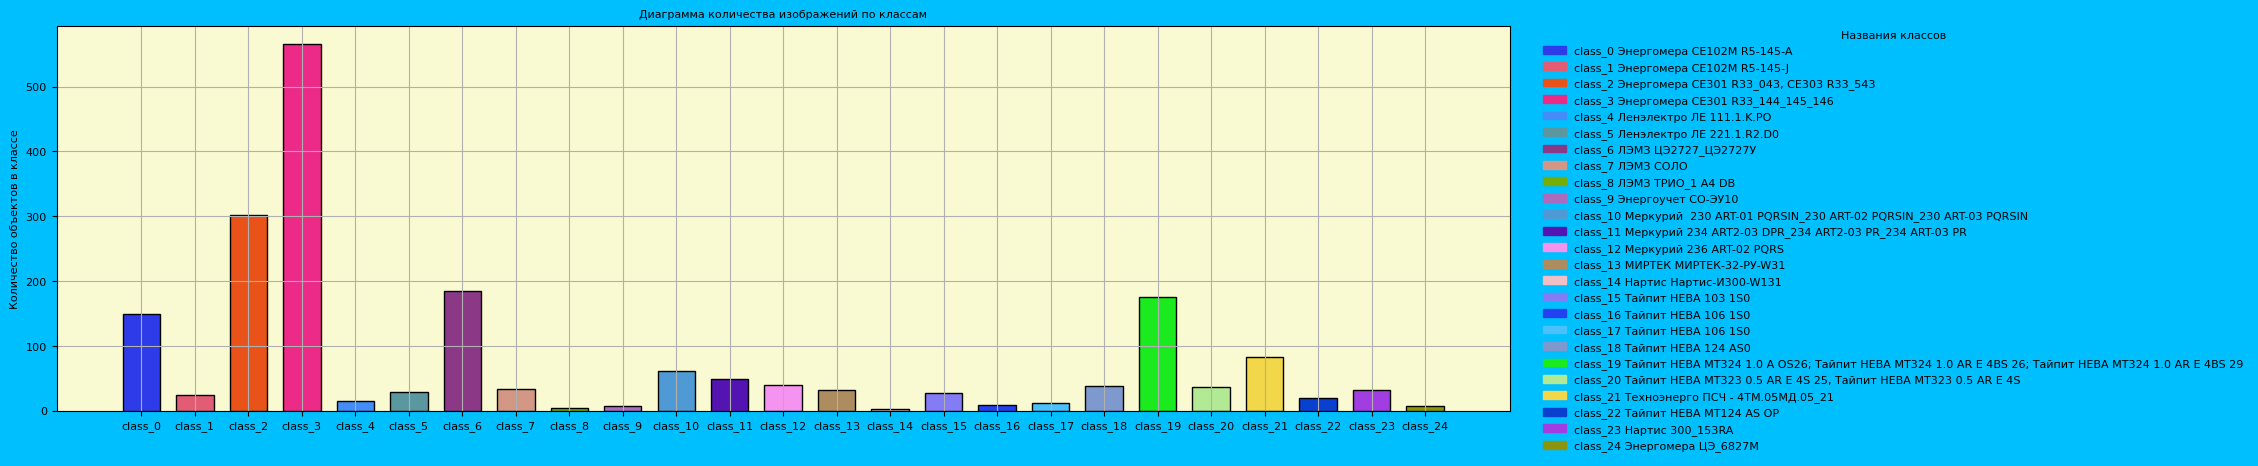

In [21]:
# выводим статистику датасета в таблицу и на график

dataset_info(source_dataset_path, 
             classes_names, 
             classes_colors, 
             header = 'Статистика датасета изображений электросчетчиков',
             classes_folders_names_type = 'index')


Распределение высоты и ширины изображений в датасете

Максимальная и минимальная высота изображений
---------------------------------------------
максимальная: 6000
Разбивка_Электро_24_классa\0\УУ ЭЭ №010556089220611.jpg
минимальная: 124
Разбивка_Электро_24_классa\17\750059f7b12fc7537a9f4fde65d60733.jpg

Максимальная и минимальная ширина изображений
---------------------------------------------
максимальная: 8000
Разбивка_Электро_24_классa\0\УУ ЭЭ №010556089220611.jpg
минимальная: 117
Разбивка_Электро_24_классa\24\24_5.jpg



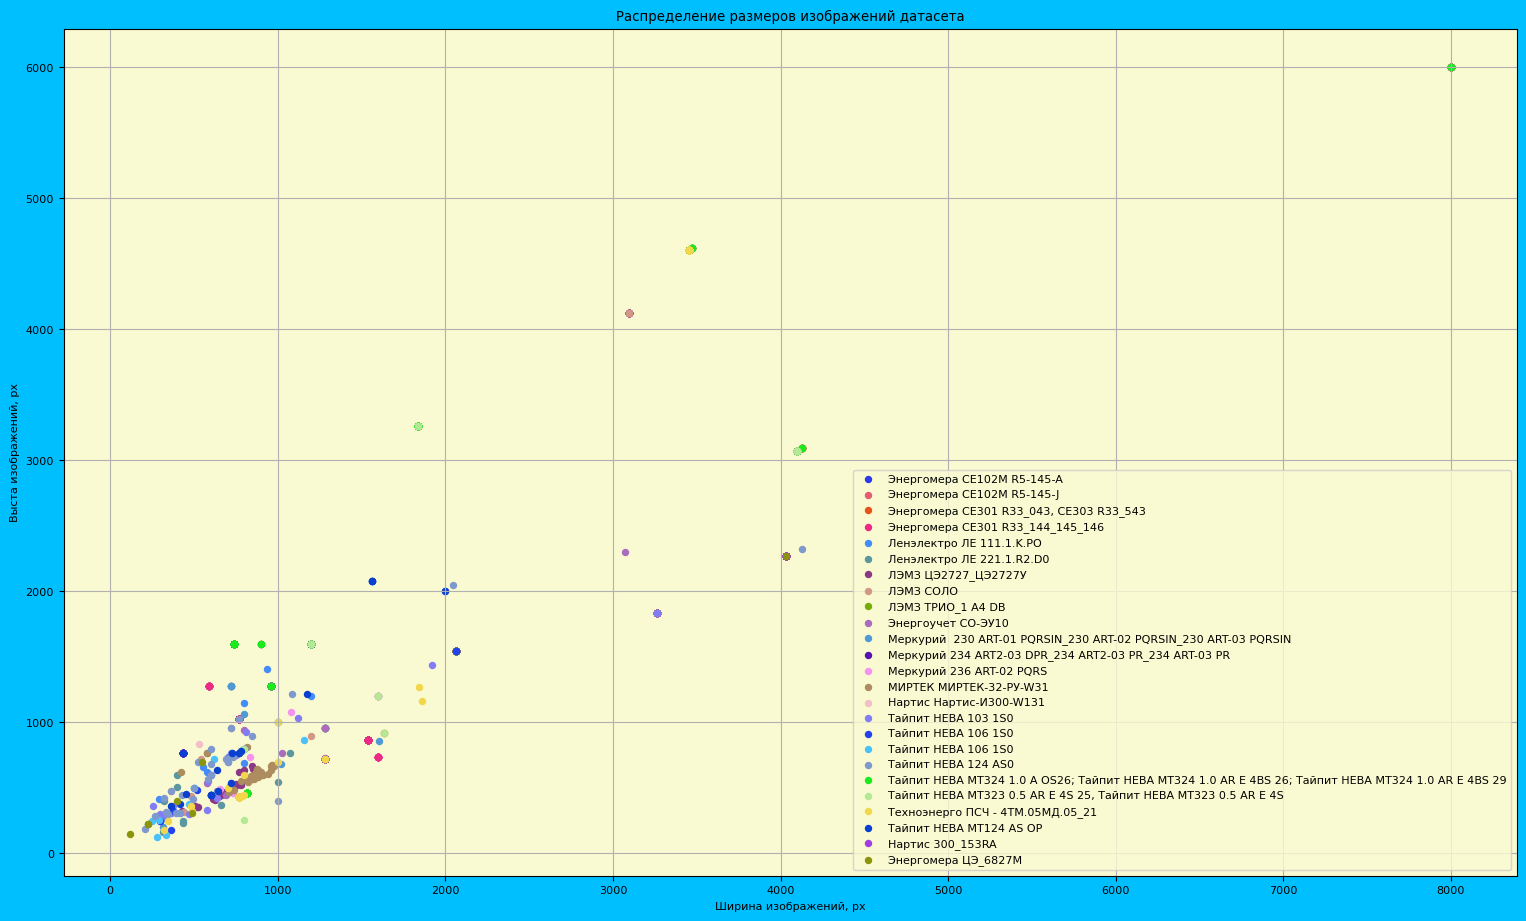

In [35]:
# скаттерплот датасета по классам

dataset_images_size_info(source_dataset_path,
                         classes_names,
                         classes_colors,
                         class_indexes_only = None,
                         images_extensions = images_extensions) 


Распределение высоты и ширины изображений в датасете по классу(ам) 0

Максимальная и минимальная высота изображений
---------------------------------------------
максимальная: 6000
Разбивка_Электро_24_классa\0\УУ ЭЭ №010556089220611.jpg
минимальная: 720
Разбивка_Электро_24_классa\0\1048136703654.jpg

Максимальная и минимальная ширина изображений
---------------------------------------------
максимальная: 8000
Разбивка_Электро_24_классa\0\УУ ЭЭ №010556089220611.jpg
минимальная: 432
Разбивка_Электро_24_классa\0\УУ ЭЭ-№010748163610048(Т)-1.jpg



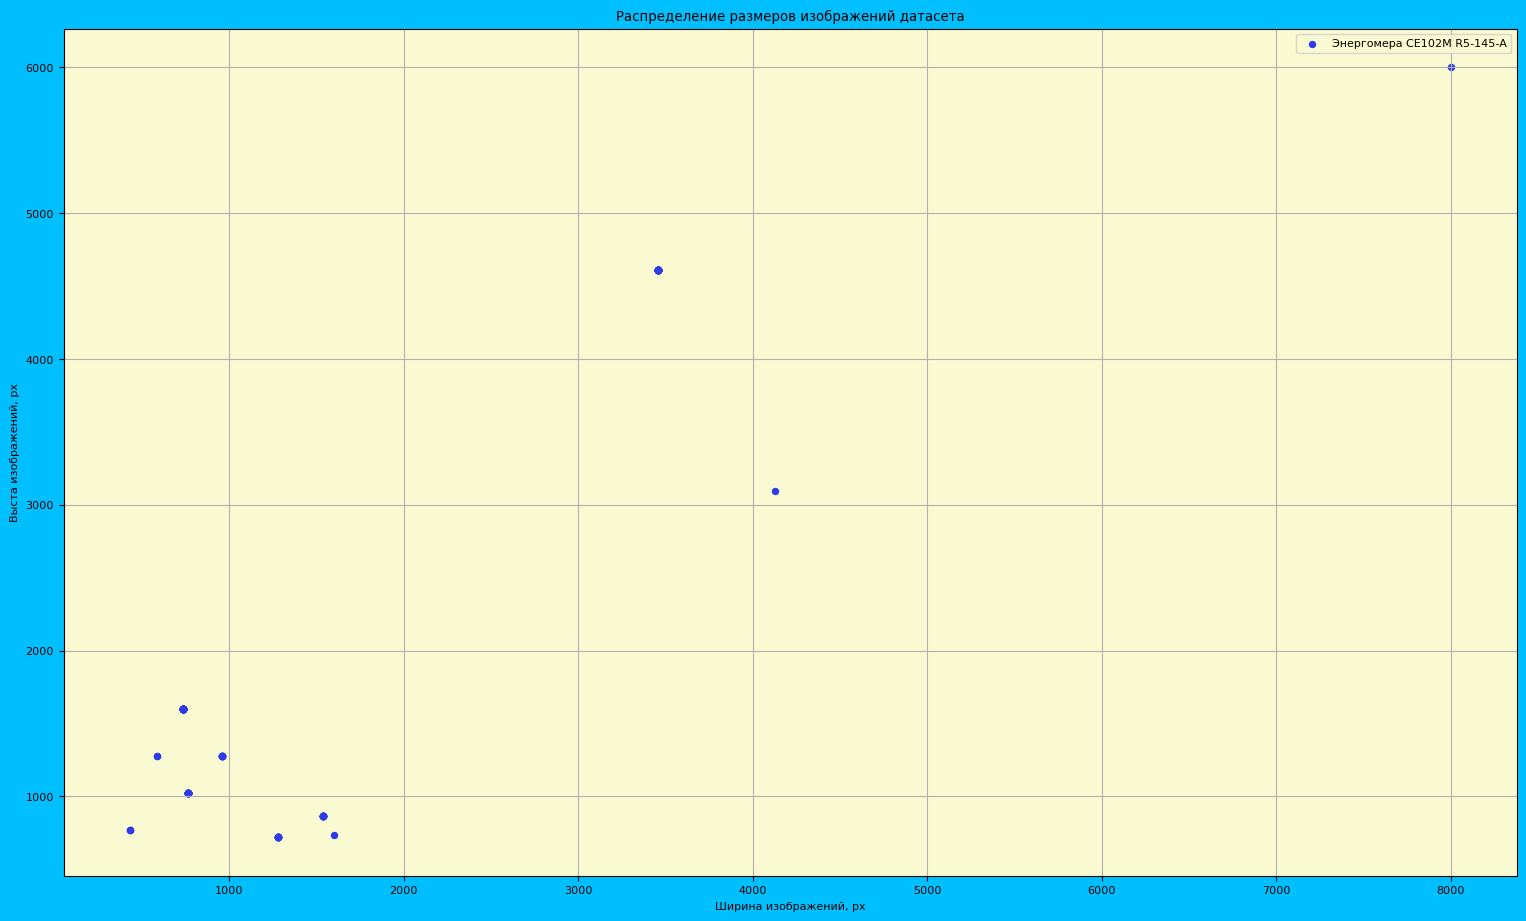

In [36]:
# скаттерплот датасета только по классу 0

dataset_images_size_info(source_dataset_path,
                         classes_names,
                         classes_colors,
                         class_indexes_only = [0],
                         images_extensions = images_extensions) 


Распределение высоты и ширины изображений в датасете по классу(ам) 1

Максимальная и минимальная высота изображений
---------------------------------------------
максимальная: 6000
Разбивка_Электро_24_классa\1\УУ ЭЭ №010556089088097.jpg
минимальная: 1280
Разбивка_Электро_24_классa\1\100198436-Т1-2.jpeg

Максимальная и минимальная ширина изображений
---------------------------------------------
максимальная: 8000
Разбивка_Электро_24_классa\1\УУ ЭЭ №010556089088097.jpg
минимальная: 590
Разбивка_Электро_24_классa\1\100198436-Т1-2.jpeg



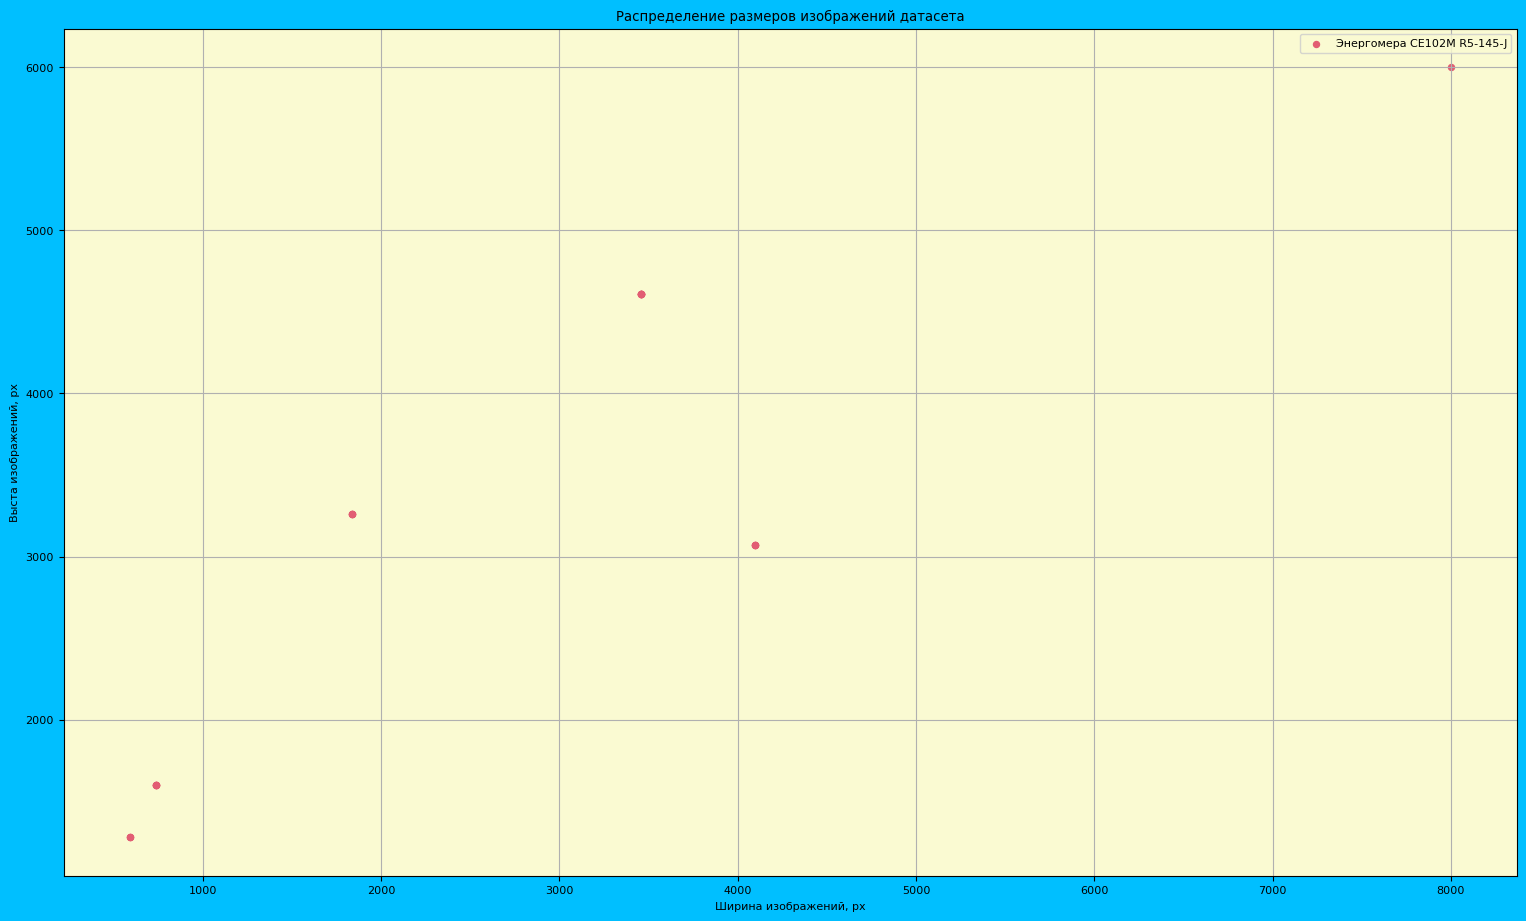

In [37]:
# скаттерплот датасета только по классу 1

dataset_images_size_info(source_dataset_path,
                         classes_names,
                         classes_colors,
                         class_indexes_only = [1],
                         images_extensions = images_extensions) 


Распределение высоты и ширины изображений в датасете по классу(ам) 2

Максимальная и минимальная высота изображений
---------------------------------------------
максимальная: 4624
Разбивка_Электро_24_классa\2\IMG_20230925_093153.jpg
минимальная: 459
Разбивка_Электро_24_классa\2\УУ ЭЭ - № 105215222-Т1.jpg

Максимальная и минимальная ширина изображений
---------------------------------------------
максимальная: 4128
Разбивка_Электро_24_классa\2\008840140227653 пож обор день.jpg
минимальная: 590
Разбивка_Электро_24_классa\2\105131689-Т1-2.jpeg



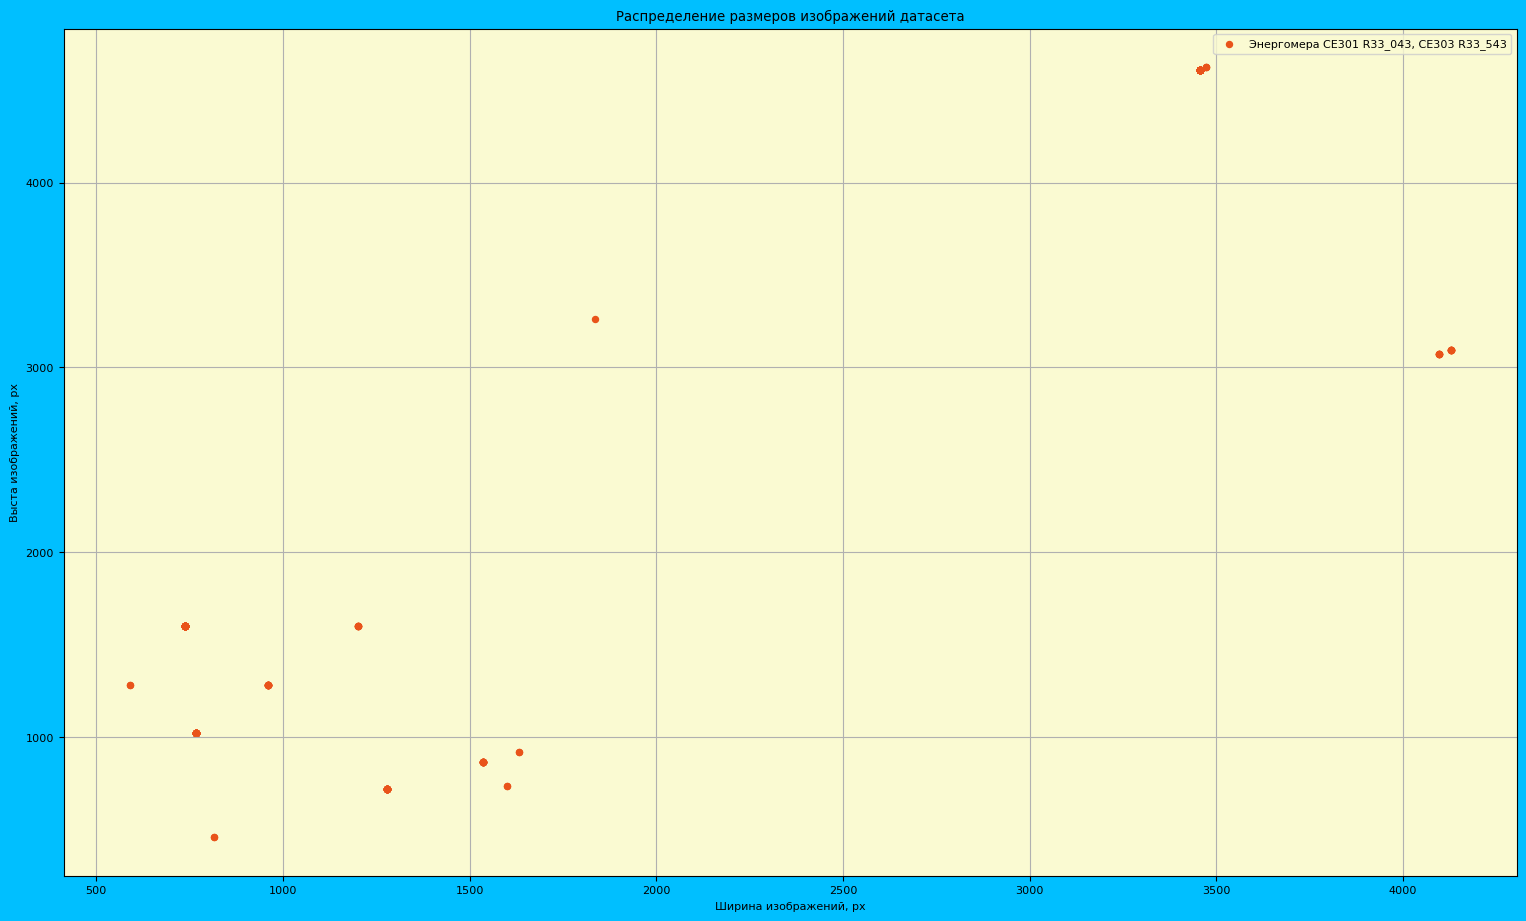

In [38]:
# скаттерплот датасета только по классу 2

dataset_images_size_info(source_dataset_path,
                         classes_names,
                         classes_colors,
                         class_indexes_only = [2],
                         images_extensions = images_extensions) 


Распределение высоты и ширины изображений в датасете по классу(ам) 5, 10, 15

Максимальная и минимальная высота изображений
---------------------------------------------
максимальная: 4608
Разбивка_Электро_24_классa\10\IMG_20230913_103604.jpg
минимальная: 161
Разбивка_Электро_24_классa\5\10.jpg

Максимальная и минимальная ширина изображений
---------------------------------------------
максимальная: 4032
Разбивка_Электро_24_классa\15\ЗБ ГРЩ 10 Консьержная пар 10.jpg
минимальная: 225
Разбивка_Электро_24_классa\5\11.jpg



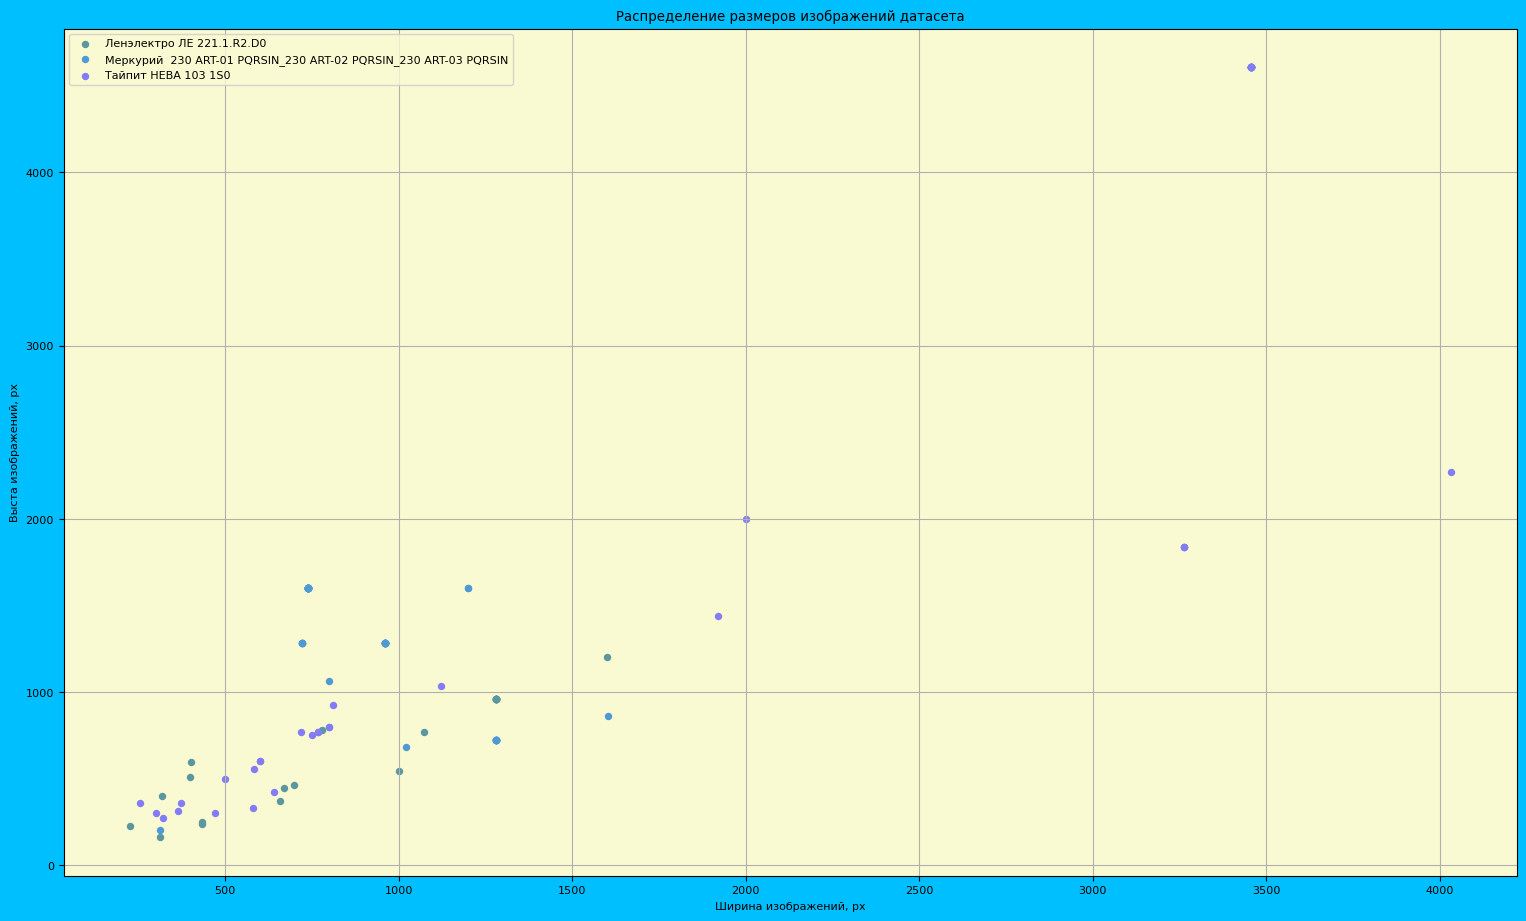

In [39]:
# скаттерплот датасета только по классам 5, 10, 15

dataset_images_size_info(source_dataset_path,
                         classes_names,
                         classes_colors,
                         class_indexes_only = [5, 10, 15],
                         images_extensions = images_extensions) 

# Проверка функций предобработки и получение датасета на 1280

In [31]:
# Отбор изображений по порогу ширины и высоты 1280 и 1280 соответственно с копированием отобранных изображений в папку
# и с созданием для дальнейшего использования словаря в переменной selected_by_1280_images_dict, 
# где ключи - индекы классов, значения - списки с путями в формате pathlib.Path изображений на изменение размера 

selected_by_1280_images_dict = select_dataset_images_by_max_size(source_dataset_path,
                                                                 'selected_by_1280_images',
                                                                 1280,
                                                                 1280,
                                                                 verbose = True,
                                                                 images_extensions = images_extensions)


*************************************************************************
Отобрано изображений по порогу ширины и высоты 1280 и 1280 соответственно
*************************************************************************

   Класс |   Отобрано изображений
---------+------------------------
       0 |                     98
       1 |                     21
       2 |                    224
       3 |                    404
       4 |                      2
       5 |                      1
       6 |                    145
       7 |                     20
       8 |                      4
       9 |                      1
      10 |                     35
      11 |                     30
      12 |                     35
      15 |                      8
      16 |                      2
      17 |                      1
      18 |                      3
      19 |                    136
      20 |                     32
      21 |                     51
      22 |                 

In [32]:
selected_by_1280_images_dict = select_dataset_images_by_max_size(source_dataset_path,
                                                                 None,
                                                                 1280,
                                                                 1280,
                                                                 verbose = False,
                                                                 images_extensions = images_extensions)

In [80]:
# создаем структуру директорий под обработанный датасет с корневой директорией 'processed_dataset_1280'

create_dataset_dirs_structure('processed_dataset_1280', len(classes_names))

In [81]:
# копируем только НЕ отобранные для изменения размера изображения из директории исходного датасета в 'processed_dataset_1280' с раскладкой по внутренним директориям классов

copy_non_selected_images(selected_by_1280_images_dict, source_dataset_path, 'processed_dataset_1280', images_extensions)

Всего скопировано изображений:  644
Всего изображений в датасете:  1935


In [82]:
# проверка суммы изображений на изменение размера и изображений без изменения размера
# должно получиться 1935 изображений, как в таблице статистики датасета выше

1291 + 644

1935

In [83]:
# Пропорциональное изменение размера изображений с сохранением обработанных изображений в директорию предобработанного датасета processed_dataset_1280,
# а так же одновременным копированием изображений после ресайза в отдельную директорию resized_by_1280_images для проверочного осмотра

resize_dataset_images_by_max_size(selected_by_1280_images_dict, 'processed_dataset_1280', 'resized_by_1280_images', 1280, verbose=True)


**********************************************
Количество обработанных по размеру изображений
**********************************************

   Класс |   Обработано изображений
---------+--------------------------
       0 |                       98
       1 |                       21
       2 |                      224
       3 |                      404
       4 |                        2
       5 |                        1
       6 |                      145
       7 |                       20
       8 |                        4
       9 |                        1
      10 |                       35
      11 |                       30
      12 |                       35
      15 |                        8
      16 |                        2
      17 |                        1
      18 |                        3
      19 |                      136
      20 |                       32
      21 |                       51
      22 |                        5
      23 |                  


Распределение высоты и ширины изображений в датасете

Максимальная и минимальная высота изображений
---------------------------------------------
максимальная: 1280
processed_dataset_1280\0\0933662268-1.jpg
минимальная: 124
processed_dataset_1280\17\750059f7b12fc7537a9f4fde65d60733.jpg

Максимальная и минимальная ширина изображений
---------------------------------------------
максимальная: 1280
processed_dataset_1280\0\093660927-1.jpg
минимальная: 117
processed_dataset_1280\24\24_5.jpg



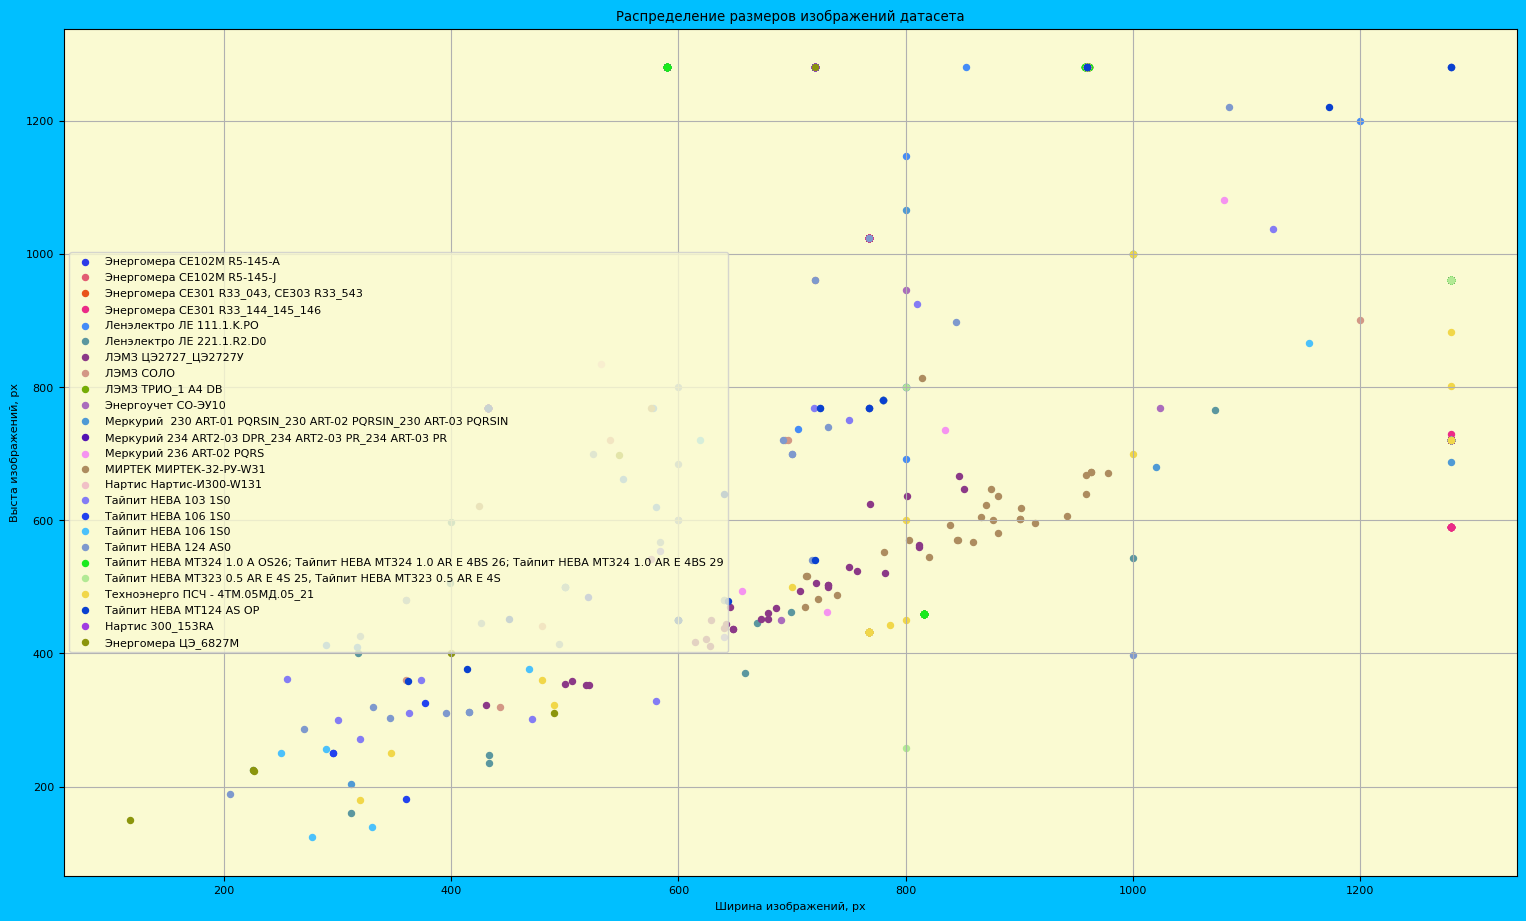

In [40]:
# Итак, в директории resized_by_1280_images предобработанный датасет полностью готов для подачи в генератор, смотрим его скаттерплот

dataset_images_size_info('processed_dataset_1280',
                         classes_names,
                         classes_colors,
                         class_indexes_only = None,
                         images_extensions = images_extensions) 

In [ ]:
# Теперь совершенно другая картина распределения размеров изображений в нужном нам диапазоне,
# работа с таким датасетом работа генератора изображений будет значительно ускорена, как и обучение нейросети

### Разворот изображения и EXIF метаданные в jpg файлах

In [53]:
test_img_path = './selected_by_1280_images/0/10748145605620 телефония.jpg'
test_img_path_1 = './selected_by_1280_images/0/093659246-1.jpg'

In [54]:
with open(test_img_path, 'rb') as test_img_obj:
    test_exif_img = exifImage(test_img_obj)
print(test_exif_img.has_exif)
print('orientation' in dir(test_exif_img))

True
True


In [55]:
test_img = Image.open(test_img_path)
hasattr(PIL.ImageOps, 'exif_transpose')

True

In [56]:
test_img._getexif()

{296: 2,
 34665: 201,
 271: 'samsung',
 272: 'SM-A105F',
 305: 'A105FPUS8CVH3',
 274: 6,
 531: 1,
 306: '2023:08:02 08:33:03',
 282: 72.0,
 283: 72.0,
 36864: b'0220',
 37377: 4.32,
 37378: 1.85,
 36867: '2023:08:02 08:33:03',
 36868: '2023:08:02 08:33:03',
 37379: -2.84,
 37380: 0.0,
 37381: 1.85,
 37383: 2,
 37385: 1,
 40960: b'0100',
 37386: 3.6,
 37510: b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00',
 40961: 1,
 37121: b'\x01\x02\x03\x00',
 40962: 4128,
 36880: '+03:00',
 36881: '+03:00',
 36882: '+03:00',
 37520: '0236',
 37521: '0236',
 37522: '0236',
 40963: 3096,
 33434: 0.05,
 40965: 848,
 33437: 1.9,
 41729: b'\x01\x00\x00\x00',
 42016: 'D13LLMA00MM',
 34850: 2,
 41985: 0,
 34855: 800,
 41986: 0,
 41987: 0,
 41988: nan,
 41989: 27,
 41990: 0,
 41992: 0,
 41993: 0,
 41994: 0}

In [57]:
test_img.show()

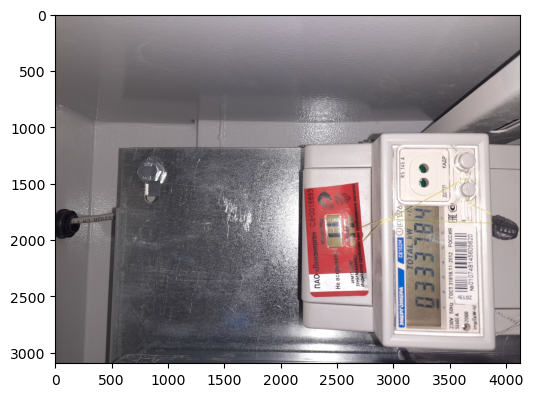

In [62]:
plt.figure(figsize=(6, 6))
plt.imshow(np.array(test_img))
plt.show()

In [63]:
test_img = ImageOps.exif_transpose(test_img)

In [64]:
test_img.show()

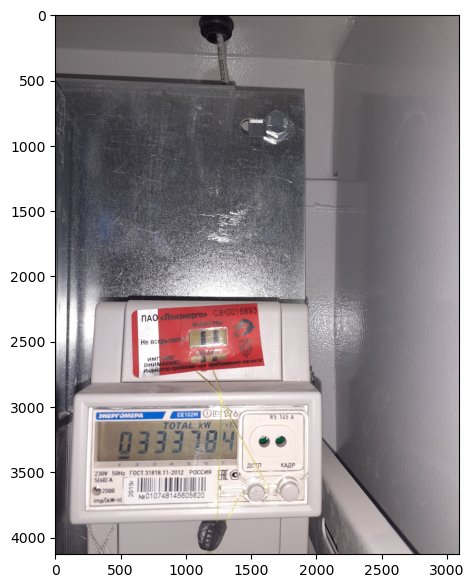

In [65]:
plt.figure(figsize=(10, 7))
plt.imshow(np.array(test_img))
plt.show()

# Предобработка датасета на 640 единой агрегирующей функцией


********************************
Предобработка датасета завершена
********************************

---------------------------------------------
Общее количество изображений в датасете: 1935
Размер датасета: 61.7 Мб
---------------------------------------------

Распределение высоты и ширины изображений в датасете

Максимальная и минимальная высота изображений
---------------------------------------------
максимальная: 640
processed_dataset_640\0\0933662268-1.jpg
минимальная: 124
processed_dataset_640\17\750059f7b12fc7537a9f4fde65d60733.jpg

Максимальная и минимальная ширина изображений
---------------------------------------------
максимальная: 640
processed_dataset_640\0\093660927-1.jpg
минимальная: 117
processed_dataset_640\24\24_5.jpg



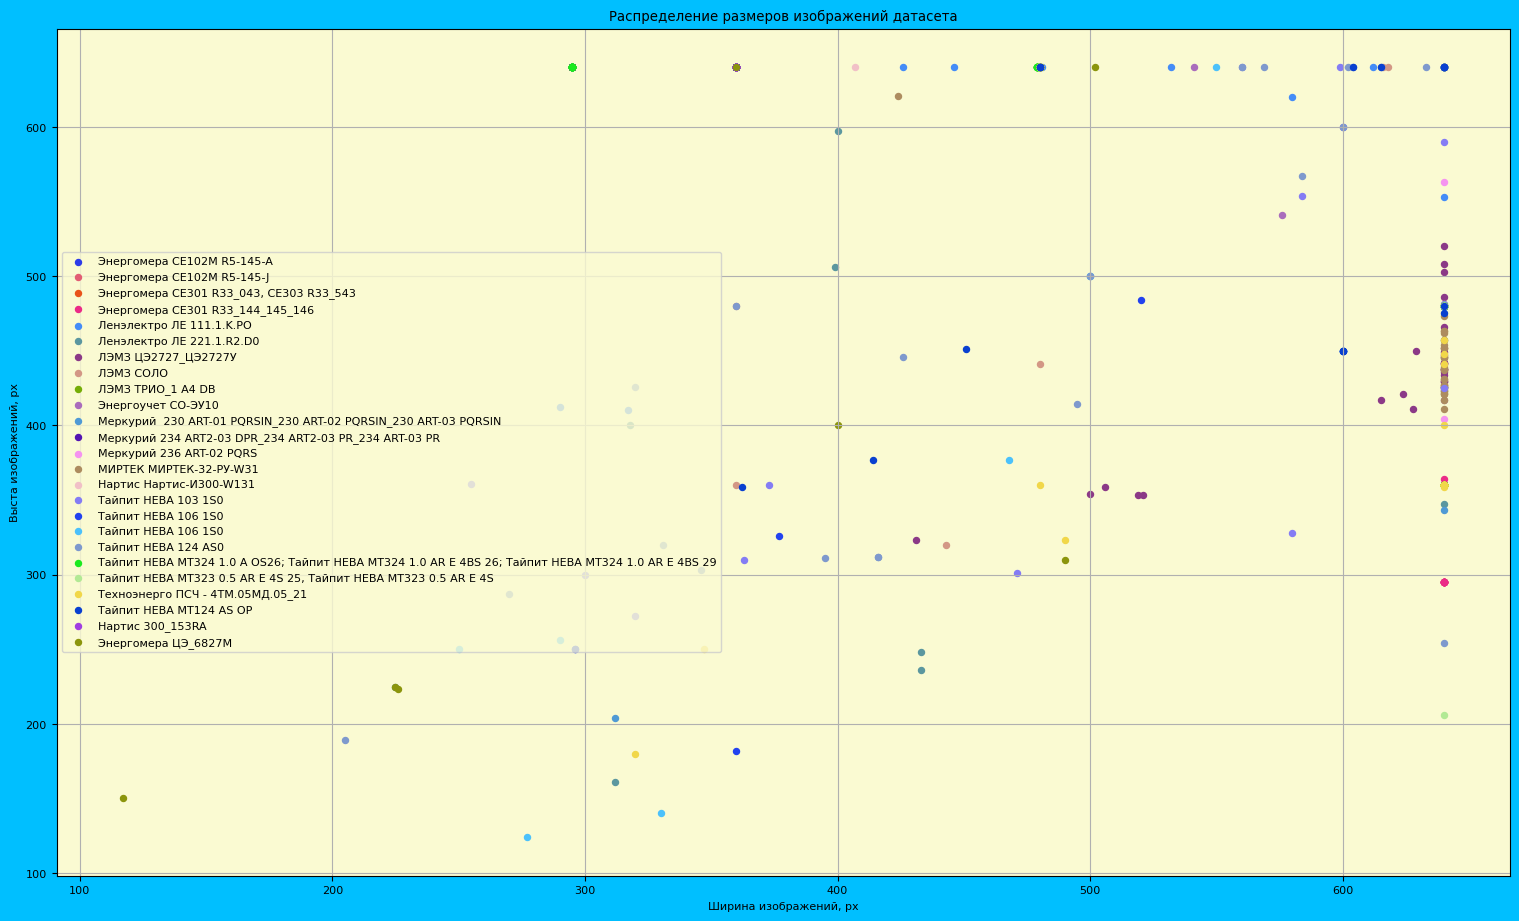

In [43]:
# подготовка датасета на 640 с помощью единой агрегирующей функции

dataset_preprocess(source_dataset_path, 
                   'processed_dataset_640', 
                   640, 
                   640, 
                   classes_names, 
                   classes_colors, 
                   images_extensions)